# 04.2 Working Geospatial Data: Raster Data 2: Joint Land Use and Elevation

In this notebook we will continue our application of Python for analyzing raster data representing the (co-registered) elevation and land use/land cover (LULC) for the Upper Boise River Basin (UBRB). In particular, this notebook demonstrates how to isolate a user-defined elevation band within the UBRB, characterize the LULC within that elevation band, and create a visualization of the distribution of LULC. This notebook uses a `numpy` feature known as a masked array that allows us to create a grid with the same dimensions as our elevation or LULC grid, but that is populated with True or False values depending on conditions that we define. The algorithm we develop will do the following:

1. Create a `numpy` masked array that is `True` where the elevation meets a given criteria and `False` everywhere else,
2. Use that masked array to get the LULC at those areas in our LULC raster that fall within the `True` mask,
3. Perform an analysis (effectively a histogram) on the returned LULC and create some visualizations.

There are definitely other ways to achieve the above workflow that don't involve masked arrays. However, masked arrays are an effective choice for many raster analyses because: (1) there are many support functions we can use in defining masked arrays (we will use `numpy.ma.masked_outside` but there are several other ways to create masked arrays as you can see [here](https://numpy.org/doc/stable/reference/maskedarray.generic.html)), (2) maked arrays are often much smaller than an underlying array of actual data (because they effectively contain only a boolean condition), allowing us to pass them around to other functions, and (3) we can use binary operators on masked arrays to perform operations where they are either true (i.e., `my_masked_array.mask`) or false (i.e., `~my_masked_array.mask`). 

## Imports and Data Paths

Load the scientific Python stack, and also bring in the NLCD color helper from `pygeohydro`. We also need to define file locations for the DEM, LULC raster, and class lookup table.

In [11]:
import numpy as np
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # <-- allows us to align the colorbar with the plot
from matplotlib.ticker import FormatStrFormatter
import pygeohydro as gh

elev_fname = '/Users/scootty/Desktop/Repositories/Data/_GEOS505_FA2025_data/ubrb_dem_30m.tif'
lulc_fname = '/Users/scootty/Desktop/Repositories/Data/_GEOS505_FA2025_data/upper_boise_landcover_30m.tif'

nlcd_cfile = '/Users/scootty/Desktop/Repositories/sf-GEOS505/Unit04-Geospatial-Data/nlcd_classifications.csv'  # Lookup table linking NLCD codes to human-readable labels


## Define Some Helpful Functions

### `z_in_range(z_array, zmin, zmax)`: Mask elevations within a target band

This helper returns a masked array that keeps only elevations inside a specified range so downstream plots can focus on a slice of terrain.

In [12]:
def z_in_range(z_array, zmin, zmax):
    """Mask elevations outside [zmin, zmax] so downstream code works on a focused slice."""
    return np.ma.masked_outside(z_array, zmin, zmax)


### `lulc_in_zrange(lulc_array_local, z_ma_local, lulc_bins_local)`: Return land-cover class counts within a masked elevation band

Given an input elevation mask, tally how many pixels of each NLCD category fall inside the slice for later normalization. Note that in the function below, we don't use a histogram function, but instead use a for loop to loop through the LULC bins. Read through the rest of the notebook and consider why that might be.

In [13]:
def lulc_in_zrange(lulc_array_local, z_ma_local, lulc_bins_local):
    """Count how many pixels of each NLCD class fall inside the elevation mask."""
    # Mask out cells outside the target elevation band
    lulc_ma = np.ma.masked_array(lulc_array_local, ~z_ma_local.mask)

    # Flatten valid land-cover values and count occurrences per NLCD code
    lulc_1d = lulc_ma.data[lulc_ma.mask]
    lulc_counts = np.zeros(lulc_bins_local.size)

    for i in np.arange(lulc_bins_local.size):
        lulc_counts[i] = np.count_nonzero(lulc_1d == lulc_bins_local[i])

    return lulc_counts


## Load rasters and summarize elevations

Open the DEM file using `rasterio`, compute basin-wide elevation stats, and print them for quick reference before filtering by range.

In [14]:
# Open the DEM and compute high-level elevation stats for context
elev_data = rio.open(elev_fname)
elev_array = elev_data.read(1)

zmin = elev_array.min()
zmax = elev_array.max()
zmean = elev_array.mean()

zstats = f'''
Elevation Statistics:
Number of columns [east-west]: {elev_array.shape[1]} 
Number of rows [north-south]: {elev_array.shape[0]}
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
'''

print(zstats)



Elevation Statistics:
Number of columns [east-west]: 5433 
Number of rows [north-south]: 3239
Minimum elevation: 853.23 m
Maximum elevation: 3259.66 m
Mean elevation: 1797.45 m



## Inspect land-cover codes

Load the NLCD raster, orient it for display, and list the unique class IDs present in the study area.

In [15]:
# Load the land-cover raster and align it so north points up in plots
lulc_data = rio.open(lulc_fname)
lulc_array = np.flipud(lulc_data.read(1)) # Flip the array vertically for correct north-up orientation

# Identify the NLCD class codes actually present inside the basin
lulc_bins = np.unique(lulc_array)

lulcstats = f'''
Land Use/Land Cover Present: {lulc_bins}
'''

print(lulcstats)



Land Use/Land Cover Present: [11 12 21 22 23 24 31 41 42 43 52 71 81 82 90 95]



## Focus on the mid-elevation band

Select elevations within ±250 m of the basin mean so we can compare land-cover types in a representative portion of the watershed.

In [16]:
# Define the elevation window centered on the mean (±250 m)
zmin_hist = zmean - 250.0
zmax_hist = zmean + 250.0

# Produce a masked DEM retaining only cells inside the elevation window
z_mid_ma = z_in_range(elev_array, zmin_hist, zmax_hist)


## Map the mid-elevation DEM slice

Visualize the masked DEM to confirm which areas fall within ±250 m of the mean elevation.

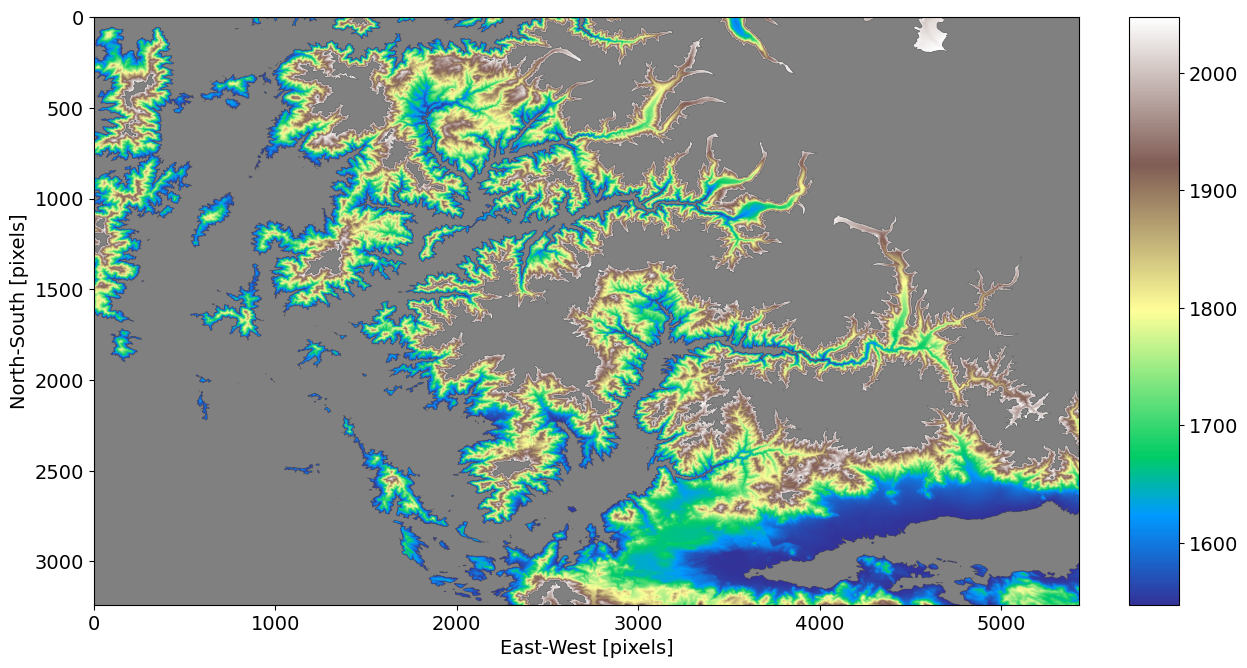

In [17]:
plt.rcParams.update({'font.size': 14})  # Improve readability of the map
fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(z_mid_ma, cmap='terrain')
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
ax.set_facecolor('gray')
divider = make_axes_locatable(ax)  # Place colorbar just outside the axes
cax = divider.new_horizontal(size='5%', pad=0.5, pack_start=False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()


## Visualize land cover within the elevation slice

Mask the land-cover grid using the same elevation filter and apply the NLCD legend so we can see which categories dominate.

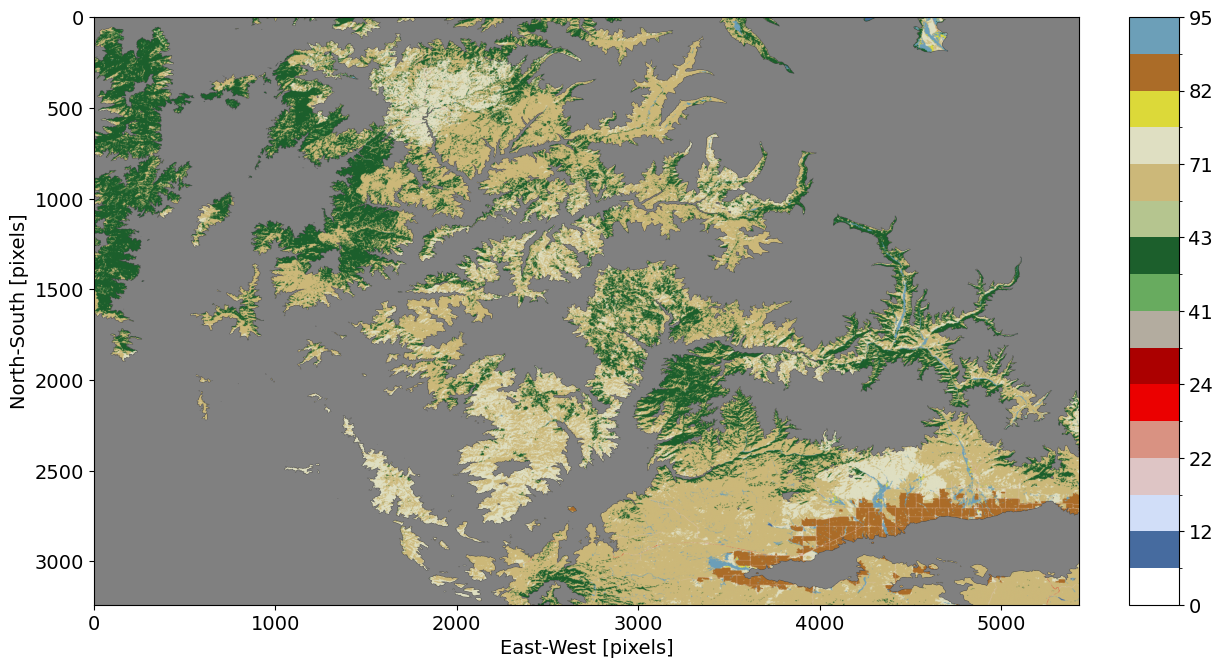

In [18]:
# Mask the land-cover raster with the same elevation filter
lulc_mid = np.ma.masked_array(lulc_array, z_mid_ma.mask)

# Use pygeohydro to retrieve the standard NLCD colormap
cmap_nlcd, norm_nlcd, levels = gh.plot.cover_legends()

# Associate NLCD codes with labels from the lookup table
nlcd_df = pd.read_csv(nlcd_cfile)

# If you wanted to create your own colormap from the lookup table, you could do something like this:
# cmap_nlcd = mcolors.ListedColormap(nlcd_df.color_code.values.astype(str),'nlcd_cmap')
# norm_nlcd = mcolors.BoundaryNorm(lulc_bins, cmap_nlcd.N)

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(lulc_mid, cmap=cmap_nlcd, norm=norm_nlcd)
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
ax.set_facecolor('gray')
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.5, pack_start=False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()


## Summarize land-cover frequencies

Collapse the masked land-cover raster into raw counts and normalized frequencies for plotting.

In [19]:
# Count NLCD classes inside the elevation slice and normalize to fractions
lulc_mid_counts = lulc_in_zrange(lulc_array, z_mid_ma, lulc_bins)

lulc_mid_freq = lulc_mid_counts / lulc_mid_counts.sum()


## Compare category proportions

Display the land-cover mix in two complementary styles: a standard bar chart using class labels and a stacked bar that highlights how the slice breaks down across NLCD classes.

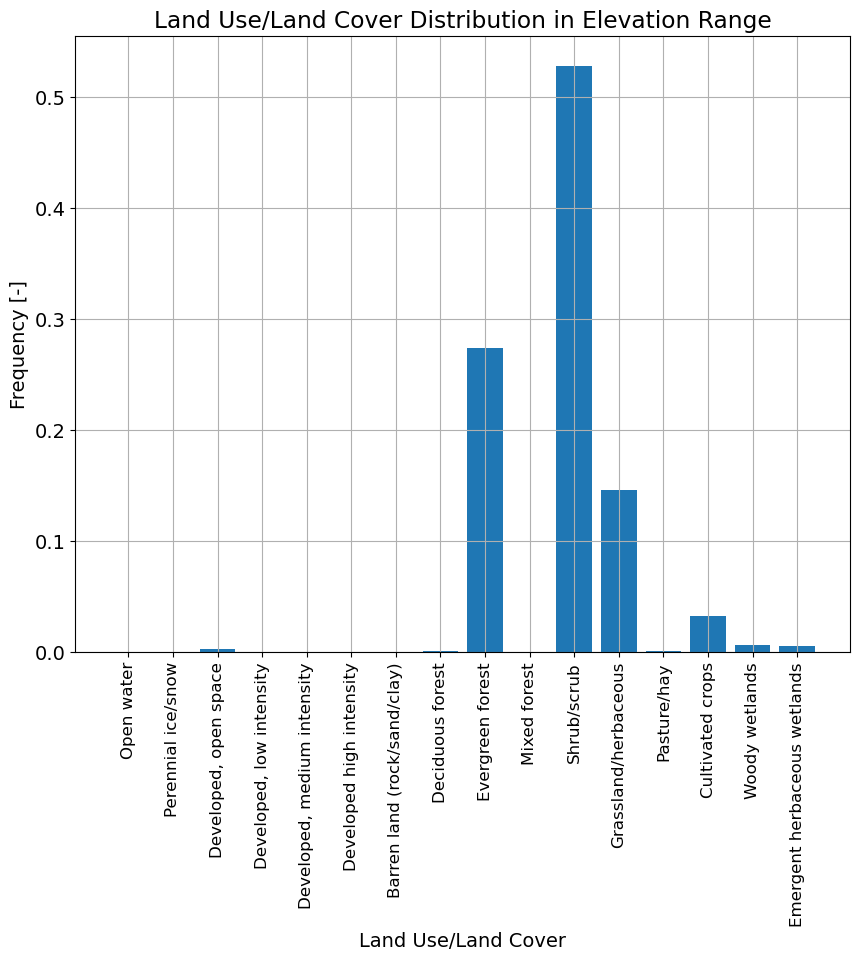

In [20]:
# Standard bar chart comparing relative frequencies by NLCD code
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(lulc_bins.astype(str), lulc_mid_freq)
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Land Use/Land Cover')
ax.set_ylabel('Frequency [-]')
ax.set_xticks(nlcd_df.id.astype(str))
ax.set_xticklabels(nlcd_df.label_short.values, rotation=90, fontsize=12)
ax.grid('on')
plt.show()


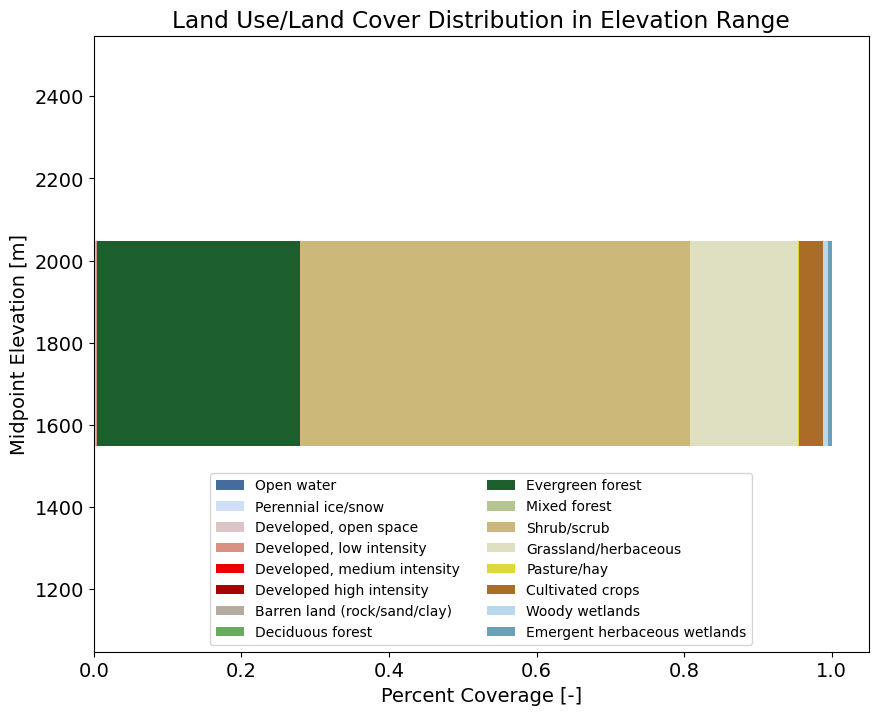

In [21]:
# Stacked horizontal bar emphasizing how the elevation band partitions among NLCD classes
fig, ax = plt.subplots(figsize=(10,8))

left = 0.0

for i in np.arange(lulc_bins.size):
    ax.barh(zmean, lulc_mid_freq[i], left=left, height=500.0, color=cmap_nlcd.colors[i+1], label=nlcd_df.label_short.values[i])
    left += lulc_mid_freq[i]

ax.set_ylim([zmean - 750.0, zmean + 750.0])
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Percent Coverage [-]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_ylabel('Midpoint Elevation [m]')
ax.legend(fontsize=10, ncol=2, loc='lower center')
plt.show()


## Wrap-up

The mid-elevation slice highlights how NLCD classes cluster around the basin mean elevation. Adjust the elevation window or swap in another watershed to see how land-cover composition shifts with topography.

Some questions for consideration:
* How might you modify the code in this notebook to examine multiple different elevation bands? 
* What are some other scientific questions we could use masked arrays more broadly to ask? 

We could use masks for more sophisticated bagging for ML methods like Spatial Leave One Out, where we randomly stratify in order to minimize spatial autocorrelation in assessed pixels/plots